In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import string 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
churn = pd.read_csv('/content/Churn.csv')
pd.set_option('display.max_columns', None)
churn.head(10)

Unnamed: 0 state      area.code  account.length voice.plan  voice.messages  \
0           1    KS  area_code_415             128        yes              25   
1           2    OH  area_code_415             107        yes              26   
2           3    NJ  area_code_415             137         no               0   
3           4    OH  area_code_408              84         no               0   
4           5    OK  area_code_415              75         no               0   
5           6    AL  area_code_510             118         no               0   
6           7    MA  area_code_510             121        yes              24   
7           8    MO  area_code_415             147         no               0   
8           9    LA  area_code_408             117         no               0   
9          10    WV  area_code_415             141        yes              37   

  intl.plan  intl.mins  intl.calls  intl.charge  day.mins  day.calls  \
0        no       10.0           3         2.70     265.1        110   
1        no       13.7           3         3.70     161.6        123   
2        no       12.2           5         3.29     243.4        114   
3       yes        6.6           7         1.78     299.4         71   
4       yes       10.1           3         2.73     166.7        113   
5       yes        6.3           6         1.70     223.4         98   
6        no        7.5           7         2.03     218.2         88   
7       yes        7.1           6         1.92     157.0         79   
8        no        8.7           4         2.35     184.5         97   
9       yes       11.2           5         3.02     258.6         84   

  day.charge eve.mins  eve.calls  eve.charge  night.mins  night.calls  \
0      45.07    197.4         99       16.78       244.7           91   
1      27.47    195.5        103       16.62       254.4          103   
2      41.38    121.2        110       10.30       162.6          104   
3       50.9     61.9         88        5.26       196.9           89   
4      28.34    148.3        122       12.61       186.9          121   
5      37.98    220.6        101       18.75       203.9          118   
6      37.09    348.5        108       29.62       212.6          118   
7      26.69    103.1         94        8.76       211.8           96   
8      31.37    351.6         80       29.89       215.8           90   
9      43.96      222        111       18.87       326.4           97   

   night.charge  customer.calls churn  
0         11.01               1    no  
1         11.45               1    no  
2          7.32               0    no  
3          8.86               2    no  
4          8.41               3    no  
5          9.18               0    no  
6          9.57               3    no  
7          9.53               0    no  
8          9.71               1    no  
9         14.69               0    no

**EXPLORATORY DATA ANALYSIS**

In [ ]:
churn.shape

(5000, 21)

In [ ]:
len(churn.state.unique())

51

In [ ]:
len(churn['area.code'].unique())

3


There are 51 states but only 3 area code which is strange.

In [ ]:
churn['area.code'].value_counts(normalize=True)*100

area_code_415    49.90
area_code_408    25.18
area_code_510    24.92
Name: area.code, dtype: float64

The area code is divided as 50%, 25% and 25% for 415, 408 and 510 area codes

In [ ]:
churn['voice.plan'].value_counts(normalize=True)*100

no     73.54
yes    26.46
Name: voice.plan, dtype: float64

Only 26% of customers have a voice plan

In [ ]:
churn['intl.plan'].value_counts(normalize=True)*100

no     90.54
yes     9.46
Name: intl.plan, dtype: float64

Only 9% of customers have an international plan

In [ ]:
#Proportion of target variable
churn.churn.value_counts(normalize=True)*100

no     85.86
yes    14.14
Name: churn, dtype: float64

Around 14% of customers churned

In [ ]:
churn.groupby('churn').agg('mean')

Unnamed: 0  account.length  voice.messages  intl.mins  intl.calls  \
churn                                                                       
no     2496.300955       99.917074        8.291870  10.190869    4.481947   
yes    2525.997171      102.332390        4.496464  10.692362    4.151344   

       intl.charge    day.mins   day.calls   eve.calls  eve.charge  \
churn                                                                
no        2.752055  175.746564   99.899604  100.241556   16.898654   
yes       2.887426  207.870580  100.817539   99.884017   17.999562   

       night.mins  night.calls  night.charge  customer.calls  
churn                                                         
no     199.455113    99.975775      8.975593        1.457722  
yes    206.078218    99.575672      9.273607        2.254597

**Missing Value Detection**

In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5000 non-null   int64  
 1   state           5000 non-null   int64  
 2   area.code       5000 non-null   object 
 3   account.length  5000 non-null   int64  
 4   voice.plan      5000 non-null   int64  
 5   voice.messages  5000 non-null   int64  
 6   intl.plan       5000 non-null   int64  
 7   intl.mins       5000 non-null   float64
 8   intl.calls      5000 non-null   int64  
 9   intl.charge     5000 non-null   float64
 10  day.mins        5000 non-null   float64
 11  day.calls       5000 non-null   int64  
 12  day.charge      5000 non-null   object 
 13  eve.mins        5000 non-null   object 
 14  eve.calls       5000 non-null   int64  
 15  eve.charge      5000 non-null   float64
 16  night.mins      5000 non-null   float64
 17  night.calls     5000 non-null   i

In [ ]:
churn[churn['day.charge'].isnull()]

Unnamed: 0  state  area.code  account.length  voice.plan  \
12            13     12        408             168           0   
27            28     26        408              54           0   
47            48      8        408             142           0   
4407        4408     42        415             125           0   
4755        4756     36        408              17           0   
4965        4966     27        408              92           0   
4992        4993     26        415              83           0   

      voice.messages  intl.plan  intl.mins  intl.calls  intl.charge  day.mins  \
12                 0          0       11.2           2         3.02     128.8   
27                 0          0       14.7           4         3.97     134.3   
47                 0          0        7.4           5         2.00     187.0   
4407               0          0        7.7           3         2.08     138.5   
4755               0          0       14.8           5         4.00     180.4   
4965               0          0       10.7           2         2.89     192.1   
4992               0          0       10.3           6         2.78     188.3   

      day.calls  day.charge  eve.mins  eve.calls  eve.charge  night.mins  \
12           96         NaN     104.9         71        8.92       141.1   
27           73         NaN     155.5        100       13.22       102.1   
47          133         NaN     134.6         74       11.44       242.2   
4407         96         NaN     159.7        117       13.57       212.7   
4755        121         NaN     228.5        111       19.42       199.5   
4965         87         NaN     193.0        122       16.41       133.4   
4992         70         NaN     243.8         88       20.72       213.7   

      night.calls  night.charge  customer.calls  churn  
12            128          6.35               1      0  
27             68          4.59               3      0  
47            127         10.90               2      0  
4407           91          9.57               2      0  
4755           99          8.98               0      0  
4965           79          6.00               1      0  
4992           79          9.62               0      0

In [ ]:
churn[churn['eve.mins'].isnull()]

Unnamed: 0  state  area.code  account.length  voice.plan  \
89            90     31        415             128           0   
102          103     46        415             135           0   
110          111     22        408             120           0   
159          160      9        510             115           1   
231          232     35        415              63           1   
254          255     43        415              97           0   
299          300     23        415              94           0   
345          346     45        415             141           0   
460          461     44        415              90           0   
557          558     43        408              58           1   
624          625      7        415             126           0   
684          685      0        408             110           0   
729          730     21        415             151           1   
750          751      1        415             146           1   
795          796      8        415              92           0   
892          893     18        415             109           1   
1012        1013     28        415             182           0   
1099        1100     11        415             157           0   
1219        1220     16        510              36           0   
1417        1418      0        408             141           0   
1483        1484     33        510             107           0   
1625        1626     48        510             100           1   
1699        1700     43        408             133           0   
1778        1779      5        510              54           1   

      voice.messages  intl.plan  intl.mins  intl.calls  intl.charge  day.mins  \
89                 0          0       13.9           4         3.75     237.9   
102                0          0       10.5           6         2.84     151.7   
110                0          0        8.3           8         2.24     165.0   
159               24          0        9.6           4         2.59     142.1   
231               36          1       11.0           6         2.97     199.0   
254                0          1       10.9           3         2.94     143.7   
299                0          0        6.6           5         1.78     181.5   
345                0          0        7.2           8         1.94     260.2   
460                0          0        9.6           5         2.59     261.8   
557               20          0        9.5           2         2.57     194.5   
624                0          0        5.1           2         1.38     161.4   
684                0          0       11.1           8         3.00     100.1   
729               26          0       13.4           5         3.62     196.5   
750               32          0        8.2           4         2.21     154.0   
795                0          0       10.8           4         2.92     197.0   
892               27          0       12.3           4         3.32     166.9   
1012               0          0        8.0           5         2.16     104.9   
1099               0          0        2.2           4         0.59     276.2   
1219               0          0       10.9           5         2.94     178.6   
1417               0          0       10.7           7         2.89      83.2   
1483               0          1       10.0           3         2.70     234.1   
1625              38          0        9.8           6         2.65     224.7   
1699               0          0        8.4           3         2.27     221.1   
1778              39          0       11.3          10         3.05     117.6   

      day.calls  day.charge  eve.mins  eve.calls  eve.charge  night.mins  \
89          125       40.44       NaN         93       21.05       208.9   
102          82       25.79       NaN        105       10.12       180.0   
110         100       28.05       NaN         83       26.96       119.2   
159         124       24.

**Treating missing values using imputation technique**

In [ ]:
churn['day.charge'].describe()

count    4993.000000
mean       30.653501
std         9.166356
min         0.000000
25%        24.430000
50%        30.620000
75%        36.750000
max        59.760000
Name: day.charge, dtype: float64

In [ ]:
churn['eve.mins'].describe()

count    4976.000000
mean      200.580326
std        50.554637
min         0.000000
25%       166.275000
50%       201.000000
75%       234.100000
max       363.700000
Name: eve.mins, dtype: float64

The means are good representational values for both features. Hence, we choose mean to impute the missing values

In [ ]:
churn['day.charge'].fillna(churn['day.charge'].mean(),inplace=True)

In [ ]:
churn['eve.mins'].fillna(churn['eve.mins'].mean(),inplace=True)

In [ ]:
churn.isnull().sum()

Unnamed: 0        0
state             0
area.code         0
account.length    0
voice.plan        0
voice.messages    0
intl.plan         0
intl.mins         0
intl.calls        0
intl.charge       0
day.mins          0
day.calls         0
day.charge        0
eve.mins          0
eve.calls         0
eve.charge        0
night.mins        0
night.calls       0
night.charge      0
customer.calls    0
churn             0
dtype: int64

**Data Type Conversion**

In [ ]:
churn.dtypes

state               int64
area.code           int64
account.length      int64
voice.plan          int64
voice.messages      int64
intl.plan           int64
intl.mins         float64
intl.calls          int64
intl.charge       float64
day.mins          float64
day.calls           int64
day.charge        float64
eve.mins          float64
eve.calls           int64
eve.charge        float64
night.mins        float64
night.calls         int64
night.charge      float64
customer.calls      int64
churn               int64
dtype: object

In [ ]:
churn['voice.plan'] = churn['voice.plan'].astype('int64')
churn['intl.plan'] = churn['intl.plan'].astype('int64')
churn['day.charge'] = churn['day.charge'].astype('float64')
churn['eve.mins'] = churn['eve.mins'].astype('float64')
churn['churn'] = churn['churn'].astype('int64')
churn['area.code'] = churn['area.code'].astype('int64')

In [ ]:
churn.dtypes

Unnamed: 0          int64
state               int64
area.code           int64
account.length      int64
voice.plan          int64
voice.messages      int64
intl.plan           int64
intl.mins         float64
intl.calls          int64
intl.charge       float64
day.mins          float64
day.calls           int64
day.charge        float64
eve.mins          float64
eve.calls           int64
eve.charge        float64
night.mins        float64
night.calls         int64
night.charge      float64
customer.calls      int64
churn               int64
dtype: object

**Dropping unnecessary columns**

In [ ]:
churn = churn.drop('Unnamed: 0',axis=1)
churn.head(2)

state  area.code  account.length  voice.plan  voice.messages  intl.plan  \
0     16        415             128           1              25          0   
1     35        415             107           1              26          0   

   intl.mins  intl.calls  intl.charge  day.mins  day.calls  day.charge  \
0       10.0           3          2.7     265.1        110       45.07   
1       13.7           3          3.7     161.6        123       27.47   

   eve.mins  eve.calls  eve.charge  night.mins  night.calls  night.charge  \
0     197.4         99       16.78       244.7           91         11.01   
1     195.5        103       16.62       254.4          103         11.45   

   customer.calls  churn  
0               1      0  
1               1      0

**Check for duplicates**

In [ ]:
churn[churn.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, state, area.code, account.length, voice.plan, voice.messages, intl.plan, intl.mins, intl.calls, intl.charge, day.mins, day.calls, day.charge, eve.mins, eve.calls, eve.charge, night.mins, night.calls, night.charge, customer.calls, churn]
Index: []

**Extracting area code**

In [ ]:
churn['area.code']=churn['area.code'].str.extract('(\d+)')

In [ ]:
churn.head(2)

Unnamed: 0 state area.code  account.length voice.plan  voice.messages  \
0           1    KS       415             128        yes              25   
1           2    OH       415             107        yes              26   

  intl.plan  intl.mins  intl.calls  intl.charge  day.mins  day.calls  \
0        no       10.0           3          2.7     265.1        110   
1        no       13.7           3          3.7     161.6        123   

  day.charge eve.mins  eve.calls  eve.charge  night.mins  night.calls  \
0      45.07    197.4         99       16.78       244.7           91   
1      27.47    195.5        103       16.62       254.4          103   

   night.charge  customer.calls churn  
0         11.01               1    no  
1         11.45               1    no

**Label Encoder**

In [ ]:
le = LabelEncoder()
churn['churn'] = le.fit_transform(churn['churn'])
churn['voice.plan'] = le.fit_transform(churn['voice.plan'])
churn['intl.plan'] = le.fit_transform(churn['intl.plan'])
churn['state'] = le.fit_transform(churn['state'])

In [ ]:
churn.head(2)

Unnamed: 0  state area.code  account.length  voice.plan  voice.messages  \
0           1     16       415             128           1              25   
1           2     35       415             107           1              26   

   intl.plan  intl.mins  intl.calls  intl.charge  day.mins  day.calls  \
0          0       10.0           3          2.7     265.1        110   
1          0       13.7           3          3.7     161.6        123   

  day.charge eve.mins  eve.calls  eve.charge  night.mins  night.calls  \
0      45.07    197.4         99       16.78       244.7           91   
1      27.47    195.5        103       16.62       254.4          103   

   night.charge  customer.calls  churn  
0         11.01               1      0  
1         11.45               1      0

**SCATTER PLOT AND CORRELATION ANALYSIS**

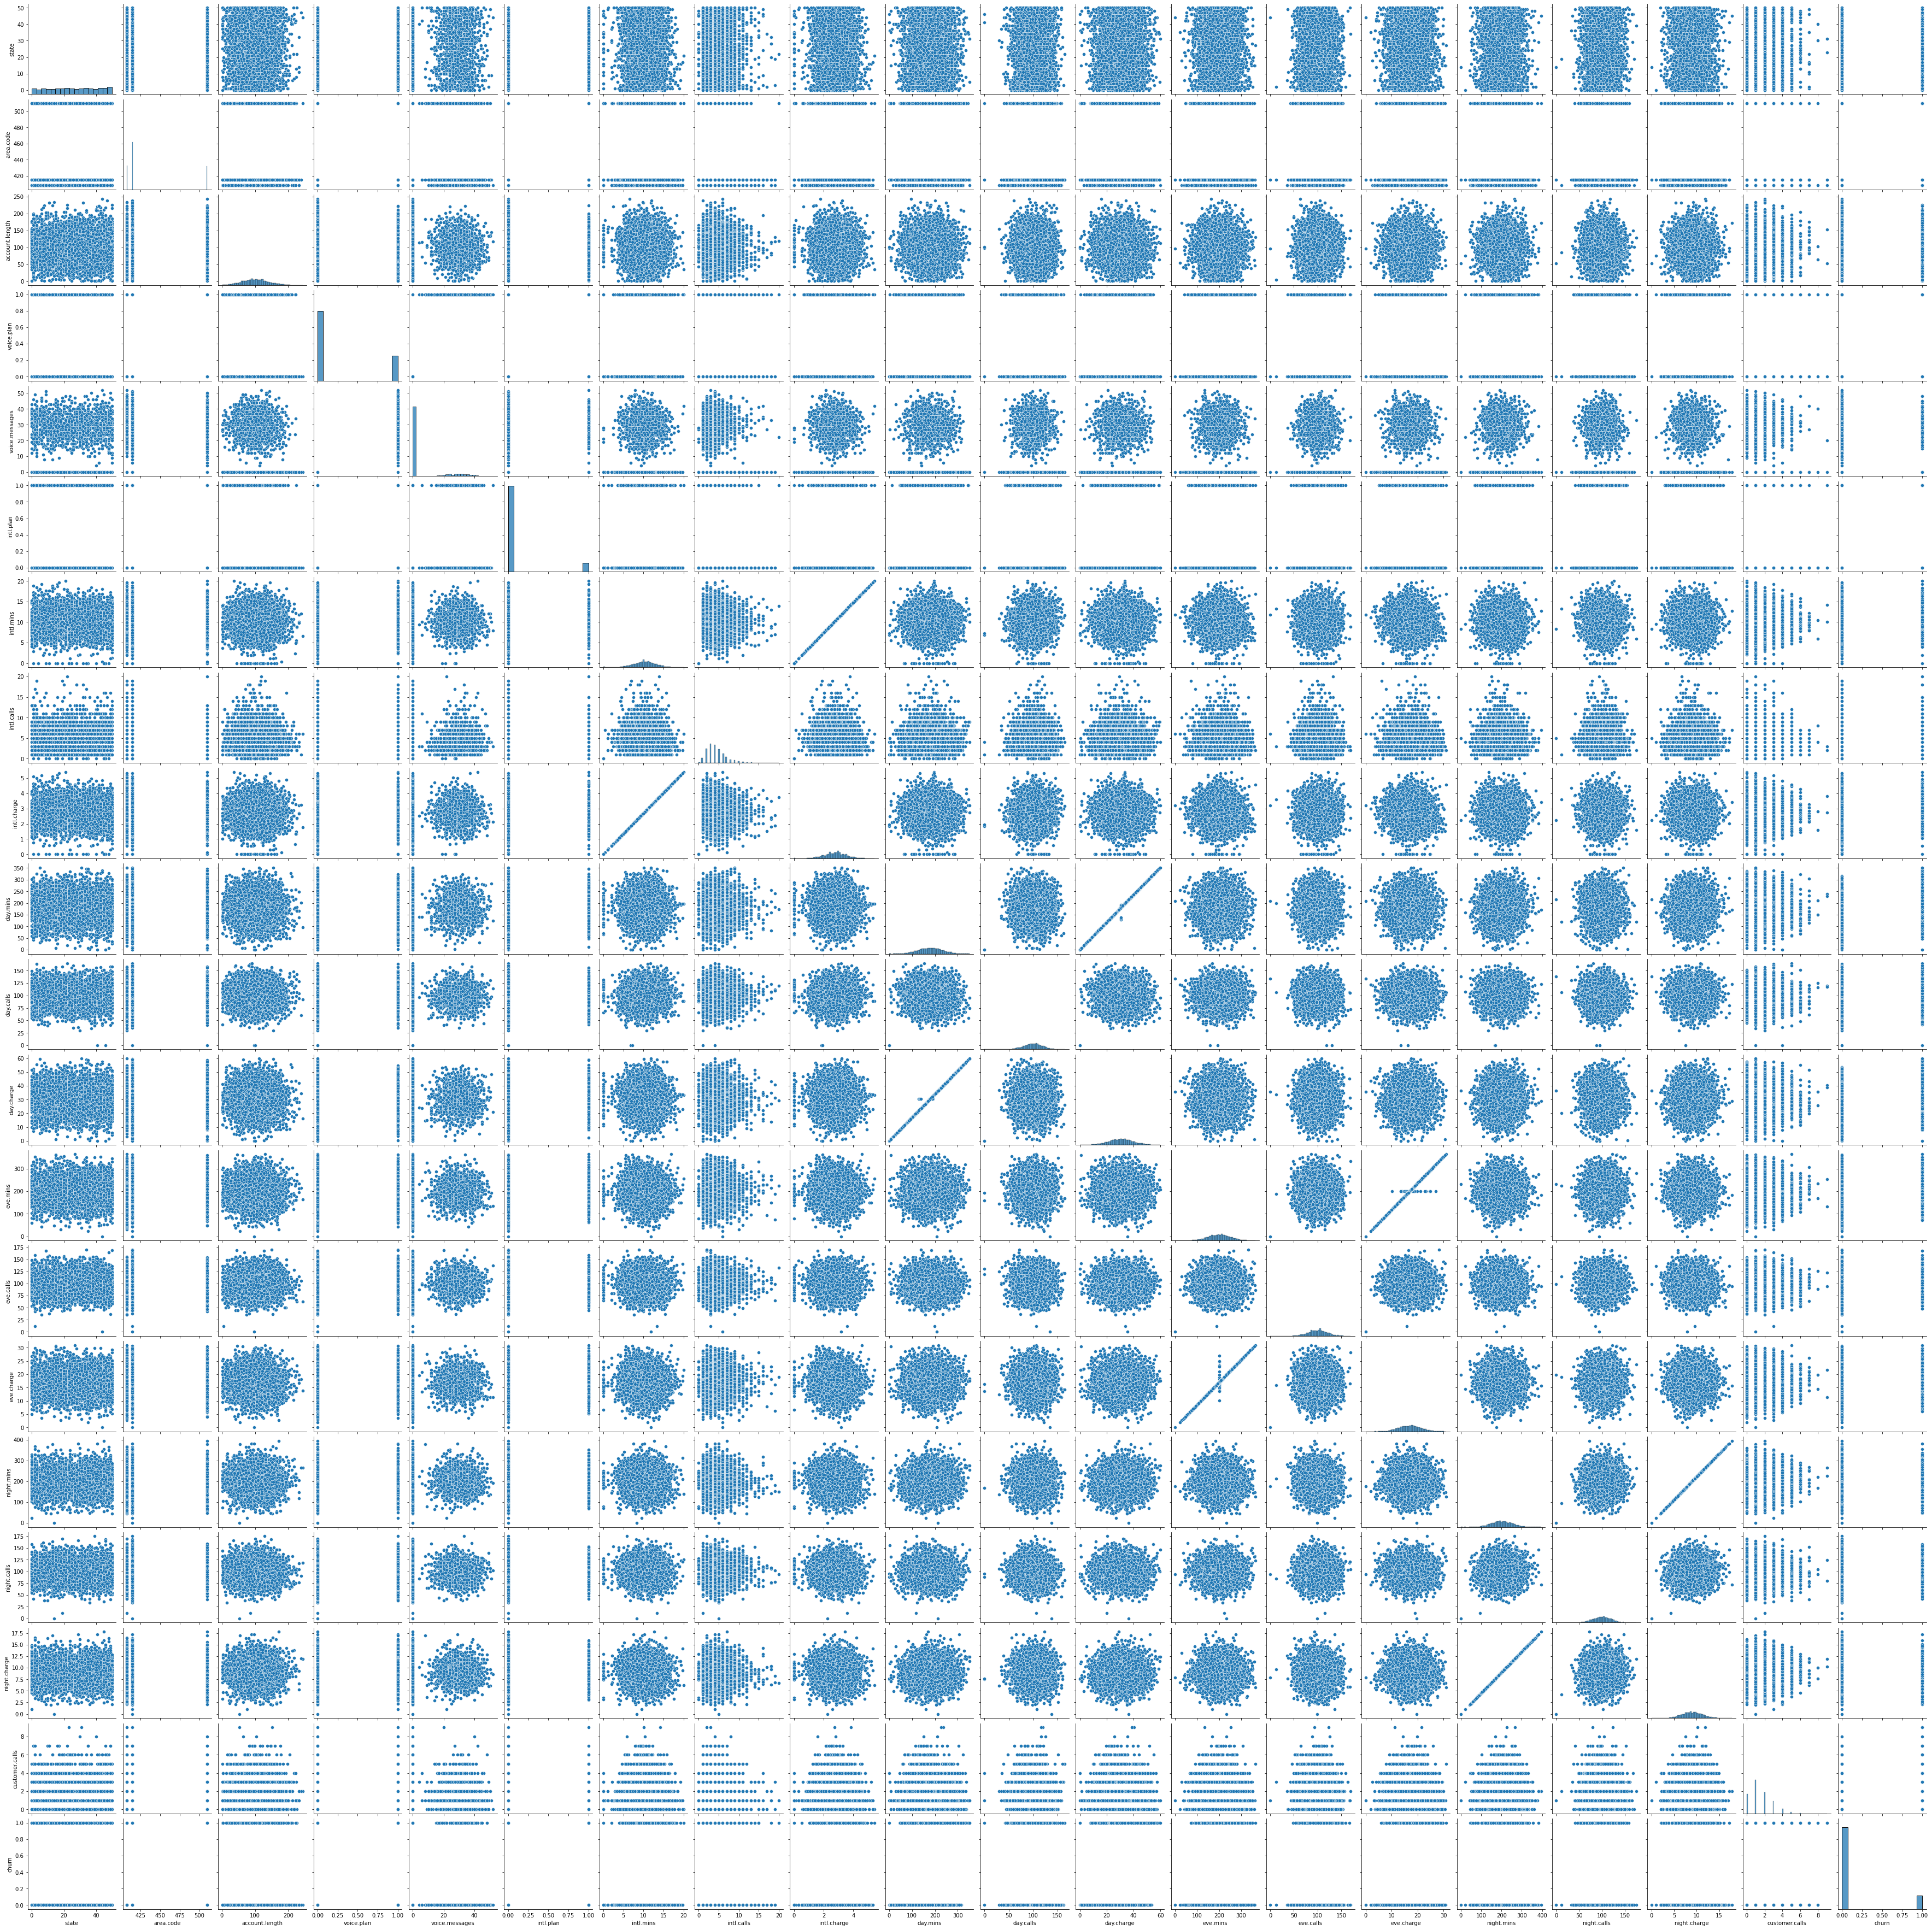

In [ ]:
sns.pairplot(data=churn)

intl.mins shows a perfect correlation with intl.charge

night.mins shows a perfect correlation with night.charge

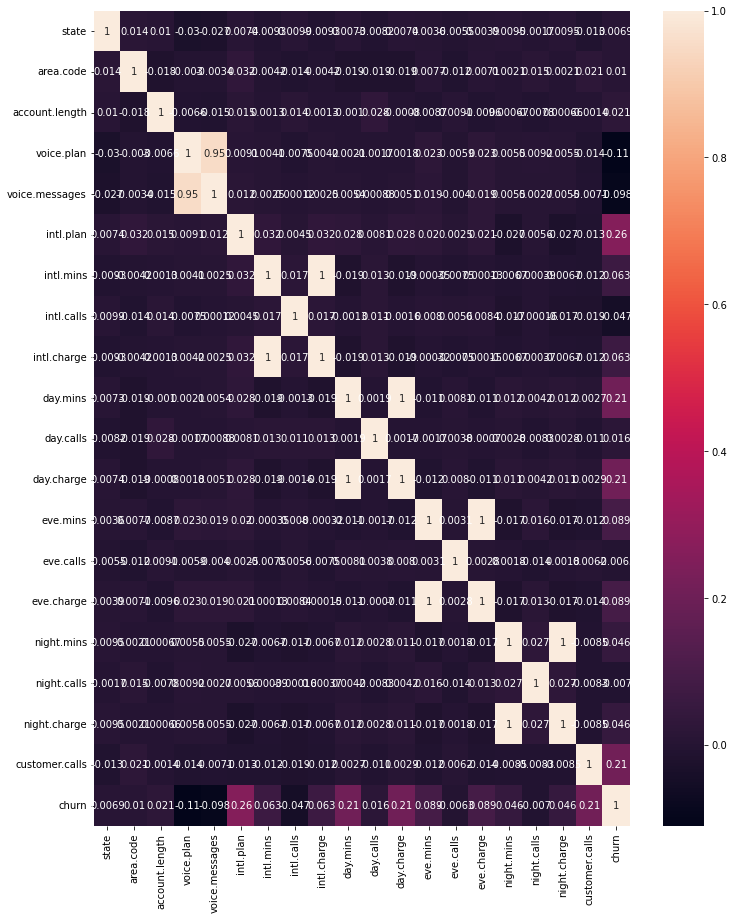

In [ ]:
fig = plt.figure(figsize=(12,15))
sns.heatmap(churn.corr(),annot=True)
plt.show()

The rest of the data is pretty much non-collinear in nature

**VISUALIZATION**

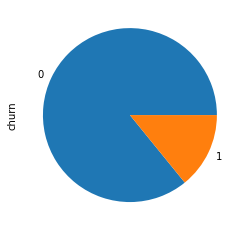

In [ ]:
churn['churn'].value_counts().plot(kind='pie')

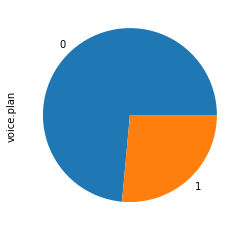

In [ ]:
churn['voice.plan'].value_counts().plot(kind='pie')

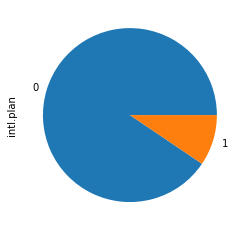

In [ ]:
churn['intl.plan'].value_counts().plot(kind='pie')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Customers who Churned')

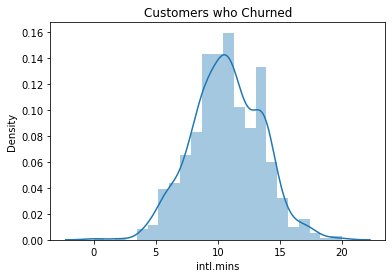

In [ ]:
churned = churn.loc[churn['churn']==1,'intl.mins'].dropna()
sns.distplot(churned)
plt.title('Customers who Churned')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Customers not Churned')

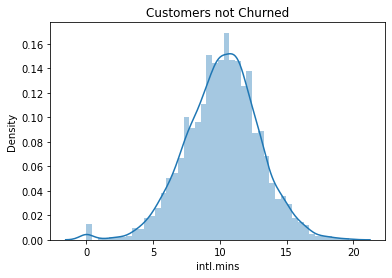

In [ ]:
not_churned = churn.loc[churn['churn']==0,'intl.mins'].dropna()
sns.distplot(not_churned)
plt.title('Customers not Churned')

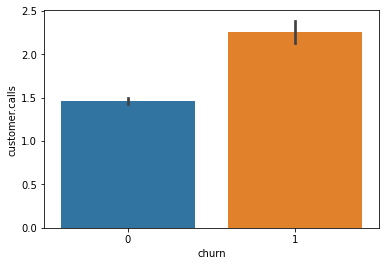

In [ ]:
sns.barplot(x='churn',y='customer.calls',data=churn)

It is interesting that the churners recieved more calls than the non-churners

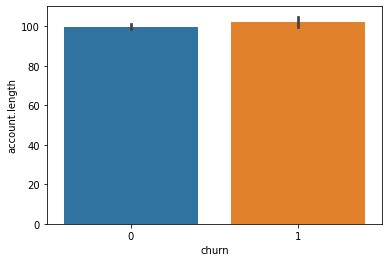

In [ ]:
sns.barplot(x='churn',y='account.length',data=churn)

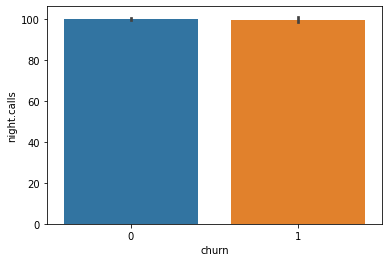

In [ ]:
sns.barplot(x='churn',y='night.calls', data=churn)

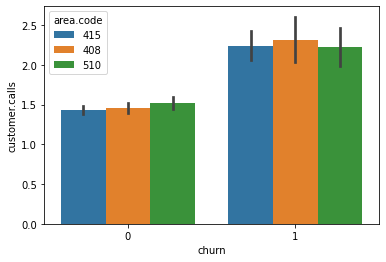

In [ ]:
sns.barplot(x='churn',y='customer.calls',hue='area.code',data=churn)

The maximum customers who churned belong to 408 area code, and the maximum non-churners belong to 519 area code

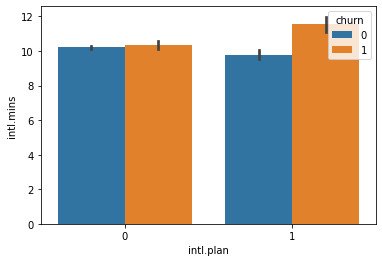

In [ ]:
sns.barplot(x='intl.plan',y='intl.mins',hue='churn',data=churn)

Even though the customers had an international plan, still their churn rate is higher than all other categories.

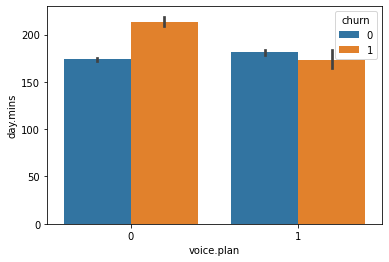

In [ ]:
sns.barplot(x='voice.plan',y='day.mins',hue='churn',data=churn)

Here the customers with no voice plan are the maximum to churn out of all other categories

Text(0.5, 0, 'Number of Voicemail Messages')

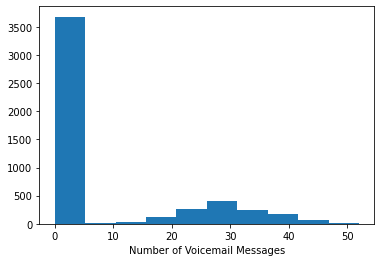

In [ ]:
plt.hist(churn['voice.messages'])
plt.xlabel('Number of Voicemail Messages')

From the frequency chart we can infer that the maximum number of voicemail messages sent out was between 0 and 5

{'whiskers': [<matplotlib.lines.Line2D at 0x7f81237ca490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f81237cab50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f81237ca130>],
 'medians': [<matplotlib.lines.Line2D at 0x7f81237d5280>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f81237d5580>],
 'means': []}

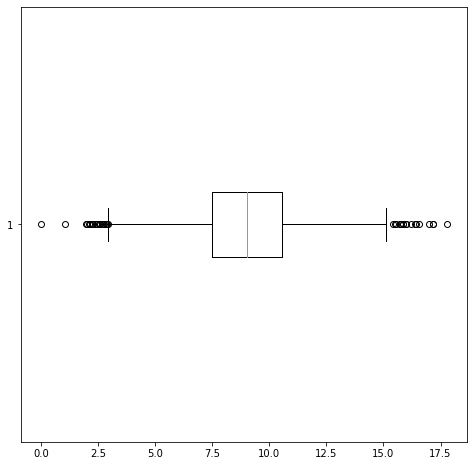

In [ ]:
plt.figure(figsize=(8,8))
plt.boxplot(churn['night.charge'],vert=False)

It is noted that the night charge follows a normal distribution

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


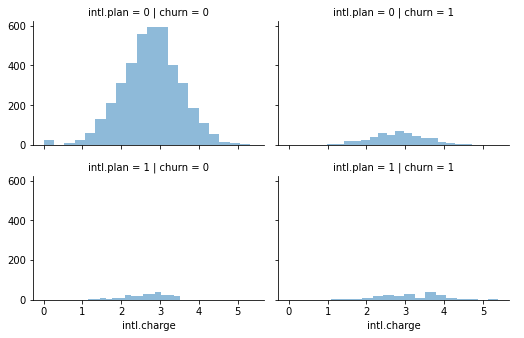

In [ ]:
# Pclass vs Survive
grid = sns.FacetGrid(churn, col='churn', row='intl.plan', size=2.4, aspect=1.5)
grid.map(plt.hist, 'intl.charge', alpha=.5, bins=20)
grid.add_legend()

The frequency for customers who didn't churn and also had no international plan is the highest compared to all other categories

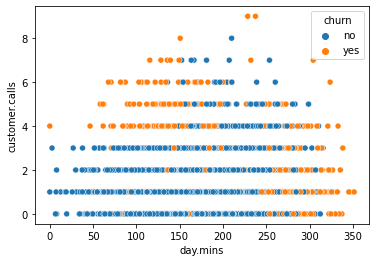

In [ ]:
sns.scatterplot(x='day.mins', y='customer.calls', data=churn, hue='churn');

The customer calls sent out to no churners is relatively low to those who churned.

**OUTLIER DETECTION**

Text(0.5, 0, 'Customer Calls')

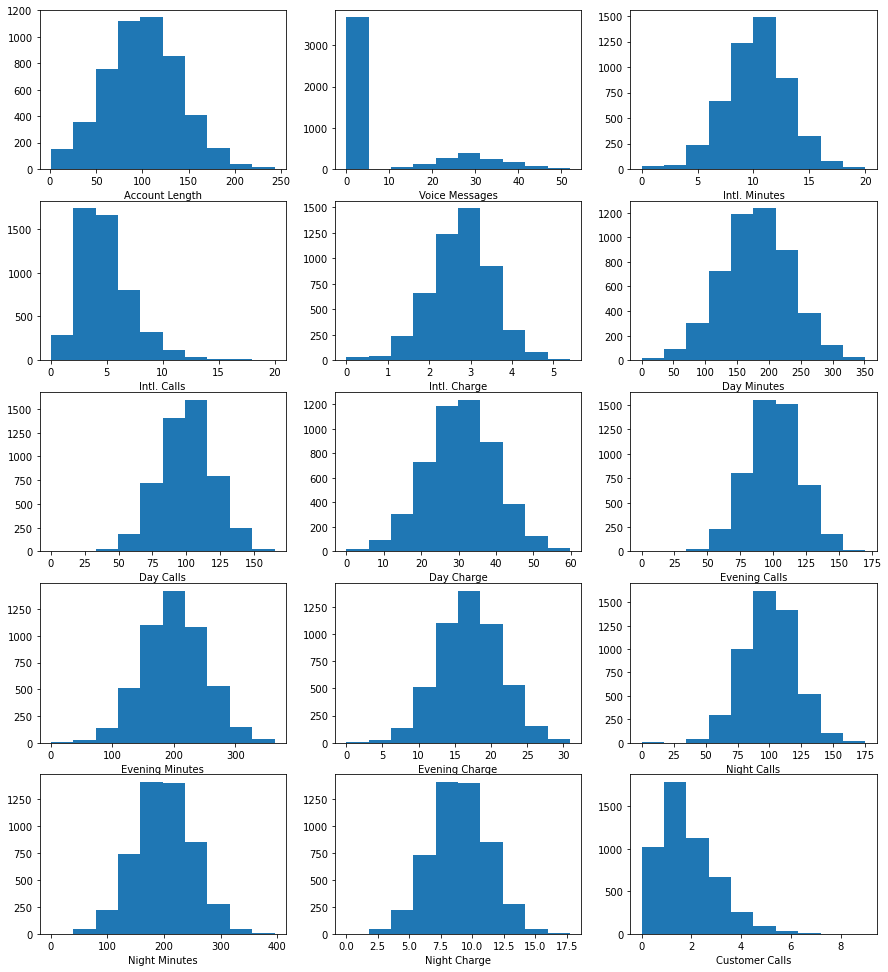

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(15,17))
ax[0][0].hist(churn['account.length'])
ax[0][0].set_xlabel('Account Length')
ax[0][1].hist(churn['voice.messages'])
ax[0][1].set_xlabel('Voice Messages')
ax[0][2].hist(churn['intl.mins'])
ax[0][2].set_xlabel('Intl. Minutes')
ax[1][0].hist(churn['intl.calls'])
ax[1][0].set_xlabel('Intl. Calls')
ax[1][1].hist(churn['intl.charge'])
ax[1][1].set_xlabel('Intl. Charge')
ax[1][2].hist(churn['day.mins'])
ax[1][2].set_xlabel('Day Minutes')
ax[2][0].hist(churn['day.calls'])
ax[2][0].set_xlabel('Day Calls')
ax[2][1].hist(churn['day.charge'])
ax[2][1].set_xlabel('Day Charge')
ax[2][2].hist(churn['eve.calls'])
ax[2][2].set_xlabel('Evening Calls')
ax[3][0].hist(churn['eve.mins'])
ax[3][0].set_xlabel('Evening Minutes')
ax[3][1].hist(churn['eve.charge'])
ax[3][1].set_xlabel('Evening Charge')
ax[3][2].hist(churn['night.calls'])
ax[3][2].set_xlabel('Night Calls')
ax[4][0].hist(churn['night.mins'])
ax[4][0].set_xlabel('Night Minutes')
ax[4][1].hist(churn['night.charge'])
ax[4][1].set_xlabel('Night Charge')
ax[4][2].hist(churn['customer.calls'])
ax[4][2].set_xlabel('Customer Calls')

From the above histograms we detect outliers in intl calls, night calls, voice messages and customer calls


Text(0.5, 0, 'Night Minutes')

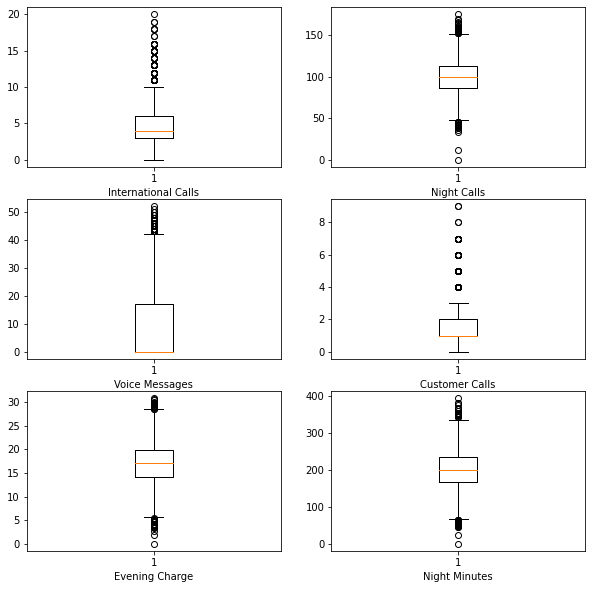

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax[0][0].boxplot(churn['intl.calls'])
ax[0][0].set_xlabel('International Calls')
ax[0][1].boxplot(churn['night.calls'])
ax[0][1].set_xlabel('Night Calls')
ax[1][0].boxplot(churn['voice.messages'])
ax[1][0].set_xlabel('Voice Messages')
ax[1][1].boxplot(churn['customer.calls'])
ax[1][1].set_xlabel('Customer Calls')
ax[2][0].boxplot(churn['eve.charge'])
ax[2][0].set_xlabel('Evening Charge')
ax[2][1].boxplot(churn['night.mins'])
ax[2][1].set_xlabel('Night Minutes')

In [ ]:
churn[(churn['night.calls']<25) & (churn['churn']==0)]

state  area.code  account.length  voice.plan  voice.messages  intl.plan  \
4410     19        408              86           0               0          0   
4707     14        415              53           0               0          0   

      intl.mins  intl.calls  intl.charge  day.mins  day.calls  day.charge  \
4410       13.3           1         3.59     118.6        106       20.16   
4707        8.3           5         2.24     214.3        138       36.43   

      eve.mins  eve.calls  eve.charge  night.mins  night.calls  night.charge  \
4410     223.5        115       19.00        94.7           12          4.26   
4707     232.2         99       19.74         0.0            0          0.00   

      customer.calls  churn  
4410               2      0  
4707               1      0

Since the ratio of the columns for night call outliers of non-chuners is low we can drop the columns

In [ ]:
churn.drop(labels=4410, inplace=True)
churn.drop(labels=4707, inplace=True)
churn.reset_index().shape

(4998, 21)

In [ ]:
churn[(churn['eve.charge']<2) & (churn['churn']==0)]

state  area.code  account.length  voice.plan  voice.messages  intl.plan  \
2932     44        415              97           0               0          0   
3370     35        415              54           0               0          0   

      intl.mins  intl.calls  intl.charge  day.mins  day.calls  day.charge  \
2932       11.8           6         3.19     209.2        134       35.56   
3370       11.1           6         3.00     255.4        122       43.42   

      eve.mins  eve.calls  eve.charge  night.mins  night.calls  night.charge  \
2932       0.0          0         0.0       175.4           94          7.89   
3370      22.3         87         1.9       152.6           72          6.87   

      customer.calls  churn  
2932               1      0  
3370               0      0

Since the ratio of the columns for Evening charge outliers of non-chuners is low we can drop the columns

In [ ]:
churn.drop(labels=[2932,3370],inplace=True)
churn.reset_index().shape

(4996, 21)

In [ ]:
churn=churn.drop(churn[(churn['intl.calls']>10) & (churn['churn']==0)].index)
print(churn.shape)

(4897, 20)


We drop the rows since they belong to the non-churners

In [ ]:
churn=churn.drop(churn[(churn['voice.messages']>40) & (churn['churn']==0)].index)
churn.shape

(4813, 20)

We drop the rows since they belong to the non-churners

In [ ]:
churn=churn.drop(churn[(churn['customer.calls']>4) & (churn['churn']==0)].index)


(4757, 20)

In [ ]:
churn.tail()

level_0  index  state  area.code  account.length  voice.plan  \
4752     4752   4994     27        408              75           0   
4753     4753   4995     11        408              50           1   
4754     4754   4996     49        415             152           0   
4755     4755   4997      7        415              61           0   
4756     4756   4998      7        510             109           0   

      voice.messages  intl.plan  intl.mins  intl.calls  intl.charge  day.mins  \
4752               0          0        6.9           7         1.86     170.7   
4753              40          0        9.9           5         2.67     235.7   
4754               0          0       14.7           2         3.97     184.2   
4755               0          0       13.6           4         3.67     140.6   
4756               0          0        8.5           6         2.30     188.8   

      day.calls  day.charge  eve.mins  eve.calls  eve.charge  night.mins  \
4752        101       29.02     193.1        126       16.41       129.1   
4753        127       40.07     223.0        126       18.96       297.5   
4754         90       31.31     256.8         73       21.83       213.6   
4755         89       23.90     172.8        128       14.69       212.4   
4756         67       32.10     171.7         92       14.59       224.4   

      night.calls  night.charge  customer.calls  churn  
4752          104          5.81               1      0  
4753          116         13.39               2      0  
4754          113          9.61               3      1  
4755           97          9.56               1      0  
4756           89         10.10               0      0

In [ ]:
churn=churn.drop(['level_0','index'],axis=1)
churn.tail()

state  area.code  account.length  voice.plan  voice.messages  intl.plan  \
4752     27        408              75           0               0          0   
4753     11        408              50           1              40          0   
4754     49        415             152           0               0          0   
4755      7        415              61           0               0          0   
4756      7        510             109           0               0          0   

      intl.mins  intl.calls  intl.charge  day.mins  day.calls  day.charge  \
4752        6.9           7         1.86     170.7        101       29.02   
4753        9.9           5         2.67     235.7        127       40.07   
4754       14.7           2         3.97     184.2         90       31.31   
4755       13.6           4         3.67     140.6         89       23.90   
4756        8.5           6         2.30     188.8         67       32.10   

      eve.mins  eve.calls  eve.charge  night.mins  night.calls  night.charge  \
4752     193.1        126       16.41       129.1          104          5.81   
4753     223.0        126       18.96       297.5          116         13.39   
4754     256.8         73       21.83       213.6          113          9.61   
4755     172.8        128       14.69       212.4           97          9.56   
4756     171.7         92       14.59       224.4           89         10.10   

      customer.calls  churn  
4752               1      0  
4753               2      0  
4754               3      1  
4755               1      0  
4756               0      0

Again the ratio is high so we cannot drop the column

**FEATURE ENGINEERING**

In [ ]:
churn.shape

(4757, 20)

In [ ]:
x = churn.iloc[:,0:19]
y = churn.iloc[:,-1]

In [ ]:
model = LogisticRegression()

In [ ]:
rfe = RFE(model, step=1)

In [ ]:
fit = rfe.fit(x,y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
fit.ranking_

array([ 8,  2, 10,  1,  1,  1,  1,  6,  3,  1,  4,  7,  5,  1,  1,  9,  1,
       11,  1])

In [ ]:
churn.columns

Index(['state', 'area.code', 'account.length', 'voice.plan', 'voice.messages',
       'intl.plan', 'intl.mins', 'intl.calls', 'intl.charge', 'day.mins',
       'day.calls', 'day.charge', 'eve.mins', 'eve.calls', 'eve.charge',
       'night.mins', 'night.calls', 'night.charge', 'customer.calls', 'churn'],
      dtype='object')

Feature Importance

'state' 7

'area.code' 3

'account.length' 10

'voice.plan' 1

'voice.messages' 1

'intl.plan' 1

'intl.mins' 1

'intl.calls' 1

'intl.charge' 5

'day.mins' 1

'day.calls' 4

'day.charge' 8

'eve.mins' 6

'eve.calls' 1

'eve.charge' 2

'night.mins' 9

'night.calls' 1

'night.charge' 11

'customer.calls' 1

In [ ]:
d = {'state':7,'area.code':3,'account.length':10,'voice.plan': 1,'voice.messages':1,'intl.plan':1,'intl.mins':1,'intl.calls':1,'intl.charge':5,'day.mins':1,'day.calls':4,'day.charge':8,'eve.mins':6,'eve.calls':1,'eve.charge':2,'night.mins':9,'night.calls':1,'night.charge':11, 'customer.calls':1}

The following chart is a representation of features in decreasing order of ranking

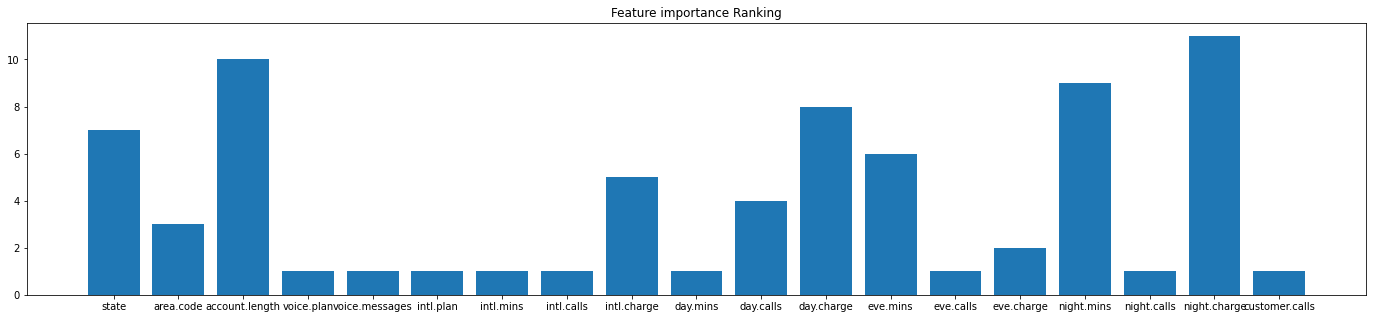

In [ ]:
fig = plt.figure(figsize=(24,5))
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()))
plt.title('Feature importance Ranking')
plt.show()

In [ ]:
churn=churn.drop(['state', 'account.length','intl.charge','day.calls','day.charge','night.mins','night.charge'], axis=1)
churn.head()

area.code  voice.plan  voice.messages  intl.plan  intl.mins  intl.calls  \
0        415           1              25          0       10.0           3   
1        415           1              26          0       13.7           3   
2        415           0               0          0       12.2           5   
3        408           0               0          1        6.6           7   
4        415           0               0          1       10.1           3   

   day.mins  eve.mins  eve.calls  eve.charge  night.calls  customer.calls  \
0     265.1     197.4         99       16.78           91               1   
1     161.6     195.5        103       16.62          103               1   
2     243.4     121.2        110       10.30          104               0   
3     299.4      61.9         88        5.26           89               2   
4     166.7     148.3        122       12.61          121               3   

   churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [ ]:
churn=churn.drop(['eve.mins'],axis=1)

In [ ]:
churn.shape

(4757, 12)

**CROSS CHECKING IMPORTANCE USING EXTRA TREES CLASSIFIER**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
model_e = ExtraTreesClassifier()

In [ ]:
model_e.fit(x,y)
pd.Series(model_e.feature_importances_,index=x.columns).sort_values(ascending=False)

day.mins          0.243412
customer.calls    0.175888
eve.charge        0.109355
intl.calls        0.095208
intl.mins         0.094195
intl.plan         0.071999
night.calls       0.070833
eve.calls         0.070811
area.code         0.031999
voice.messages    0.023211
voice.plan        0.013088
dtype: float64

**SPLITTING THE DATA**

In [ ]:
x = churn.iloc[:,0:11]
y = churn.iloc[:,-1]

**FEATURE SCALING**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

**SPLITTING THE DATA**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33,random_state=42)

**MODEL BUILDING**

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_log = LogisticRegression(max_iter=500)

In [ ]:
model_log.fit(x_train,y_train)

LogisticRegression(max_iter=500)

In [ ]:
y_pred_test=model_log.predict(x_test)
y_pred_train=model_log.predict(x_train)

In [ ]:
pd.DataFrame({'Actual':y_test,'Predicted':y_pred_test})

Actual  Predicted
2313       0          0
315        0          0
2328       1          0
472        0          0
534        0          0
...      ...        ...
1289       0          0
449        0          0
3747       0          0
3998       0          0
958        0          0

[1570 rows x 2 columns]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(pd.crosstab(y_test,y_pred_test))

col_0     0   1
churn          
0      1308  23
1       195  44


In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1331
           1       0.66      0.18      0.29       239

    accuracy                           0.86      1570
   macro avg       0.76      0.58      0.61      1570
weighted avg       0.84      0.86      0.83      1570



In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2719
           1       0.63      0.19      0.29       468

    accuracy                           0.86      3187
   macro avg       0.75      0.58      0.61      3187
weighted avg       0.84      0.86      0.83      3187



In [ ]:
acc_1=np.round(np.mean(y_pred_test==y_test),4)*100
acc_1

86.11

In [ ]:
acct_1=np.round(np.mean(y_pred_train==y_train),4)*100
acct_1

86.44

**Decision Tree Using Entropy Criterion**

In [ ]:
from sklearn import tree

In [ ]:
model_entropy = DecisionTreeClassifier(criterion='entropy',max_depth=3)

In [ ]:
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

[Text(0.5, 0.875, 'night.calls <= 0.389\nentropy = 0.602\nsamples = 3187\nvalue = [2719, 468]\nclass = yes'),
 Text(0.25, 0.625, 'day.mins <= 0.722\nentropy = 0.509\nsamples = 2971\nvalue = [2635, 336]\nclass = yes'),
 Text(0.125, 0.375, 'intl.plan <= 0.5\nentropy = 0.37\nsamples = 2688\nvalue = [2497, 191]\nclass = yes'),
 Text(0.0625, 0.125, 'entropy = 0.25\nsamples = 2441\nvalue = [2339, 102]\nclass = yes'),
 Text(0.1875, 0.125, 'entropy = 0.943\nsamples = 247\nvalue = [158, 89]\nclass = yes'),
 Text(0.375, 0.375, 'voice.plan <= 0.5\nentropy = 1.0\nsamples = 283\nvalue = [138, 145]\nclass = no'),
 Text(0.3125, 0.125, 'entropy = 0.945\nsamples = 218\nvalue = [79, 139]\nclass = no'),
 Text(0.4375, 0.125, 'entropy = 0.444\nsamples = 65\nvalue = [59, 6]\nclass = yes'),
 Text(0.75, 0.625, 'day.mins <= 0.456\nentropy = 0.964\nsamples = 216\nvalue = [84, 132]\nclass = no'),
 Text(0.625, 0.375, 'day.mins <= 0.395\nentropy = 0.345\nsamples = 93\nvalue = [6, 87]\nclass = no'),
 Text(0.5625, 0

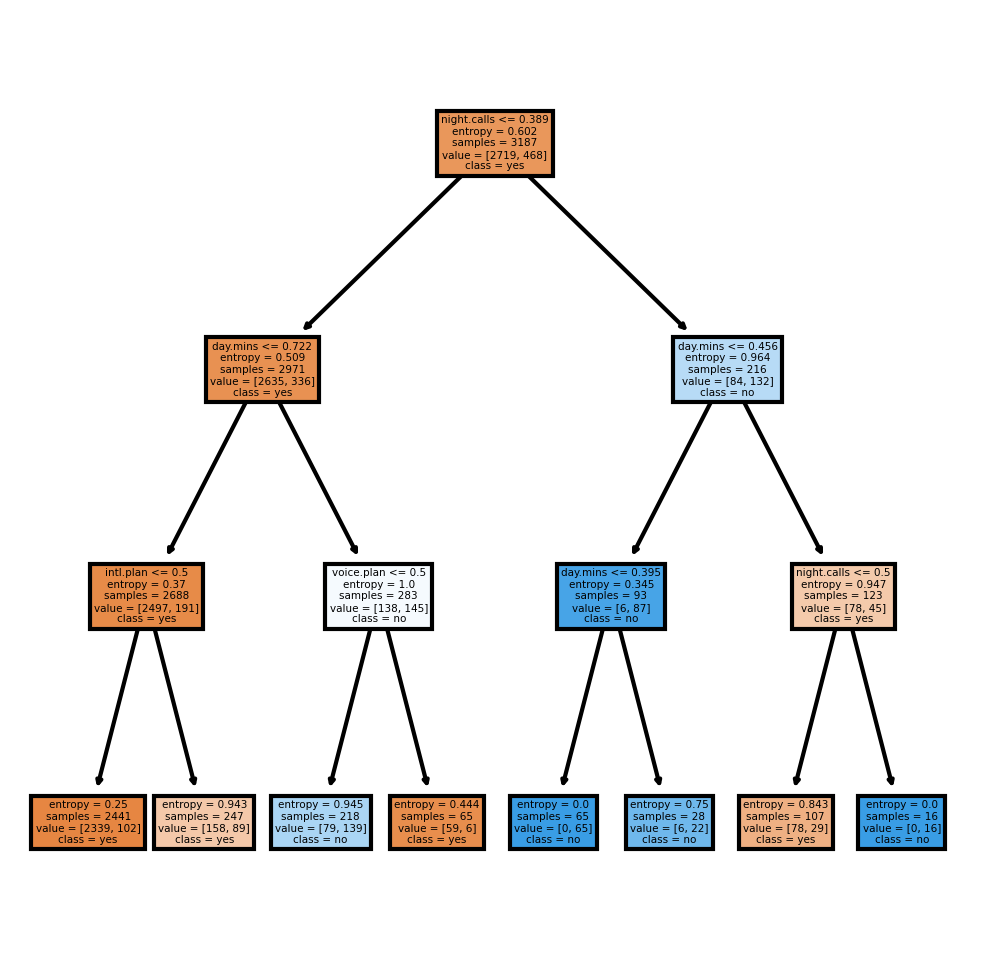

In [ ]:
fn = ['area.code',	'voice.plan',	'voice.messages',	'intl.plan',	'intl.mins',	'intl.calls',	'day.mins',	'eve.mins',	'eve.calls',	'eve.charge',	'night.calls',	'customer.calls']
cn = ['yes','no']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(model_entropy,
               feature_names = fn, 
               class_names=cn,
               filled = True)

In [ ]:
y_pred_test_1 = model_entropy.predict(x_test)
y_pred_train_1 = model_entropy.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_1))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1331
           1       0.77      0.49      0.60       239

    accuracy                           0.90      1570
   macro avg       0.84      0.73      0.77      1570
weighted avg       0.89      0.90      0.89      1570



In [ ]:
print(classification_report(y_train,y_pred_train_1))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2719
           1       0.74      0.52      0.61       468

    accuracy                           0.90      3187
   macro avg       0.83      0.74      0.78      3187
weighted avg       0.89      0.90      0.89      3187



In [ ]:
pd.DataFrame({'Actual':y_test,'Predicted':y_pred_test_1})

Actual  Predicted
2313       0          0
315        0          0
2328       1          1
472        0          0
534        0          0
...      ...        ...
1289       0          0
449        0          0
3747       0          0
3998       0          0
958        0          0

[1570 rows x 2 columns]

In [ ]:
acc_2=np.round(np.mean(y_test==y_pred_test_1),4)*100
acc_2

90.0

In [ ]:
acct_2=np.round(np.mean(y_train==y_pred_train_1),4)*100
acct_2

90.24

In [ ]:
pd.crosstab(y_test,y_pred_test_1)

col_0     0    1
churn           
0      1297   34
1       123  116

**Decision Tree Using Gini Criterion**

In [ ]:
model_gini = DecisionTreeClassifier(criterion='gini',max_depth=3)

In [ ]:
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3)

[Text(0.5, 0.875, 'night.calls <= 0.389\nentropy = 0.602\nsamples = 3187\nvalue = [2719, 468]\nclass = yes'),
 Text(0.25, 0.625, 'day.mins <= 0.722\nentropy = 0.509\nsamples = 2971\nvalue = [2635, 336]\nclass = yes'),
 Text(0.125, 0.375, 'intl.plan <= 0.5\nentropy = 0.37\nsamples = 2688\nvalue = [2497, 191]\nclass = yes'),
 Text(0.0625, 0.125, 'entropy = 0.25\nsamples = 2441\nvalue = [2339, 102]\nclass = yes'),
 Text(0.1875, 0.125, 'entropy = 0.943\nsamples = 247\nvalue = [158, 89]\nclass = yes'),
 Text(0.375, 0.375, 'voice.plan <= 0.5\nentropy = 1.0\nsamples = 283\nvalue = [138, 145]\nclass = no'),
 Text(0.3125, 0.125, 'entropy = 0.945\nsamples = 218\nvalue = [79, 139]\nclass = no'),
 Text(0.4375, 0.125, 'entropy = 0.444\nsamples = 65\nvalue = [59, 6]\nclass = yes'),
 Text(0.75, 0.625, 'day.mins <= 0.456\nentropy = 0.964\nsamples = 216\nvalue = [84, 132]\nclass = no'),
 Text(0.625, 0.375, 'day.mins <= 0.395\nentropy = 0.345\nsamples = 93\nvalue = [6, 87]\nclass = no'),
 Text(0.5625, 0

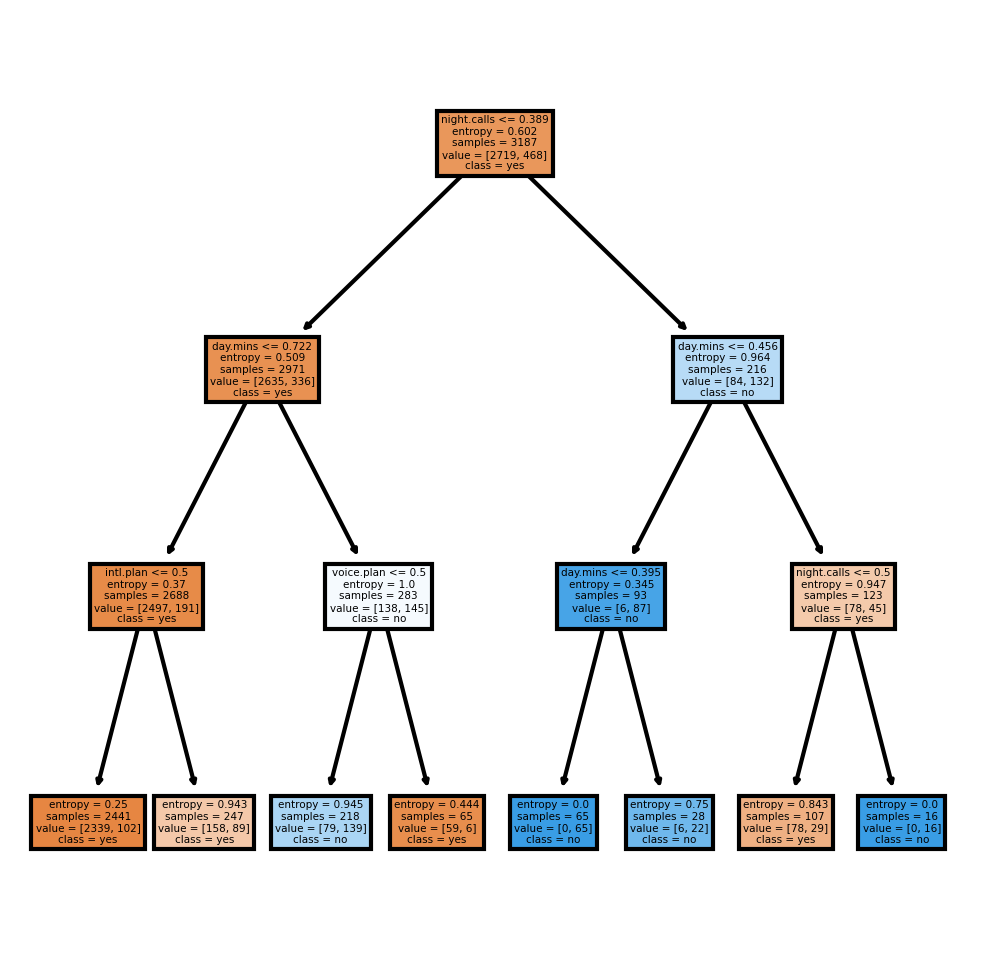

In [ ]:
fn = ['area.code',	'voice.plan',	'voice.messages',	'intl.plan',	'intl.mins',	'intl.calls',	'day.mins',	'eve.mins',	'eve.calls',	'eve.charge',	'night.calls',	'customer.calls']
cn = ['yes','no']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(model_entropy,
               feature_names = fn, 
               class_names=cn,
               filled = True)

In [ ]:
y_pred_test_2=model_gini.predict(x_test)
y_pred_train_2=model_gini.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_2))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1331
           1       0.92      0.32      0.48       239

    accuracy                           0.89      1570
   macro avg       0.90      0.66      0.71      1570
weighted avg       0.89      0.89      0.87      1570



In [ ]:
print(classification_report(y_train,y_pred_train_2))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2719
           1       0.94      0.40      0.57       468

    accuracy                           0.91      3187
   macro avg       0.92      0.70      0.76      3187
weighted avg       0.91      0.91      0.89      3187



In [ ]:
acc_3=np.round(np.mean(y_pred_test_2==y_test),4)*100
acc_3

89.24

In [ ]:
acct_3=np.round(np.mean(y_pred_train_2==y_train),4)*100
acct_3

90.86999999999999

In [ ]:
pd.DataFrame({'Actual':y_test,'Predicted':y_pred_test_2})

Actual  Predicted
2313       0          0
315        0          0
2328       1          1
472        0          0
534        0          0
...      ...        ...
1289       0          0
449        0          0
3747       0          0
3998       0          0
958        0          0

[1570 rows x 2 columns]

**Deciding the number of K in KNN using KMeans Clustering**

In [ ]:
from sklearn.cluster import KMeans

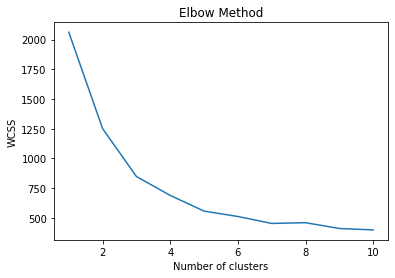

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(x_train,y_train)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**K-Nearest Neighbors**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
kfold = KFold(n_splits=10)
model_neighbors = KNeighborsClassifier(n_neighbors=5)
results = cross_val_score(model_neighbors, x_train, y_train, cv=kfold)

In [ ]:
print(results.mean()*100)

89.70909485223082


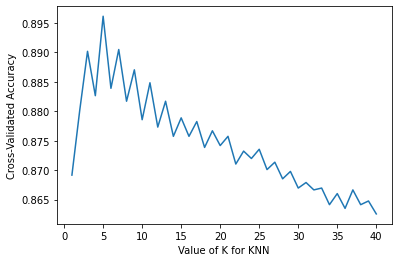

In [ ]:
# choose k between 1 to 41
k_range = range(1, 41)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5)
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [ ]:
model_neighbors.fit(x_train,y_train)

KNeighborsClassifier()

In [ ]:
y_pred_test_3=model_neighbors.predict(x_test)
y_pred_train_3=model_neighbors.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_3))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1331
           1       0.80      0.36      0.49       239

    accuracy                           0.89      1570
   macro avg       0.85      0.67      0.72      1570
weighted avg       0.88      0.89      0.87      1570



In [ ]:
print(classification_report(y_train,y_pred_train_3))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2719
           1       0.93      0.52      0.67       468

    accuracy                           0.92      3187
   macro avg       0.93      0.76      0.81      3187
weighted avg       0.92      0.92      0.91      3187



In [ ]:
pd.crosstab(y_test,y_pred_test_3)

col_0     0   1
churn          
0      1310  21
1       154  85

In [ ]:
acc_4=np.round(np.mean(y_test==y_pred_test_3),4)*100
acc_4

88.85

In [ ]:
acct_4=np.round(np.mean(y_train==y_pred_train_3),4)*100
acct_4

92.38

In [ ]:
pd.DataFrame({'Actual':y_test,'Predicted':y_pred_test_3})

Actual  Predicted
2313       0          0
315        0          0
2328       1          0
472        0          0
534        0          0
...      ...        ...
1289       0          0
449        0          0
3747       0          0
3998       0          0
958        0          0

[1570 rows x 2 columns]

**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = SVC()
param_grid = [{'kernel':['rbf'],'gamma':[50,5,10,0.5],'C':[15,14,13,12,11,10,0.1,0.001] }] #Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
gsv = GridSearchCV(clf,param_grid,cv=10)
gsv.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [15, 14, 13, 12, 11, 10, 0.1, 0.001],
                          'gamma': [50, 5, 10, 0.5], 'kernel': ['rbf']}])

In [ ]:
gsv.best_params_, gsv.best_score_

({'C': 11, 'gamma': 5, 'kernel': 'rbf'}, 0.9237534748920566)

In [ ]:
clf = SVC(C=11,gamma=5,kernel='rbf')

In [ ]:
clf.fit(x_train,y_train)

SVC(C=11, gamma=5)

In [ ]:
y_pred_test_4=clf.predict(x_test)
y_pred_train_4=clf.predict(x_train)

In [ ]:
pd.crosstab(y_test,y_pred_test_4)

col_0     0    1
churn           
0      1301   30
1        88  151

In [ ]:
acc_5=np.round(np.mean(y_pred_test_4==y_test),4)*100
acc_5

92.47999999999999

In [ ]:
acct_5=np.round(np.mean(y_pred_train_4==y_train),4)*100
acct_5

97.3

In [ ]:
print(classification_report(y_test,y_pred_test_4))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1331
           1       0.83      0.63      0.72       239

    accuracy                           0.92      1570
   macro avg       0.89      0.80      0.84      1570
weighted avg       0.92      0.92      0.92      1570



In [ ]:
print(classification_report(y_train,y_pred_train_4))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2719
           1       0.97      0.84      0.90       468

    accuracy                           0.97      3187
   macro avg       0.97      0.92      0.94      3187
weighted avg       0.97      0.97      0.97      3187



In [ ]:
pd.DataFrame({'Actual':y_test,'Predicted':y_pred_test_4})

Actual  Predicted
2313       0          0
315        0          0
2328       1          1
472        0          0
534        0          0
...      ...        ...
1289       0          0
449        0          0
3747       0          0
3998       0          0
958        0          0

[1570 rows x 2 columns]

**Naive Bayes Classification**

In [ ]:
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.naive_bayes import MultinomialNB as MB

In [ ]:
clfMB = MB()
clfMB.fit(x_train,y_train)

MultinomialNB()

In [ ]:
y_pred_test_5=clfMB.predict(x_test)
y_pred_train_5=clfMB.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_5))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1331
           1       0.00      0.00      0.00       239

    accuracy                           0.85      1570
   macro avg       0.42      0.50      0.46      1570
weighted avg       0.72      0.85      0.78      1570



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(y_train,y_pred_train_5))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2719
           1       0.00      0.00      0.00       468

    accuracy                           0.85      3187
   macro avg       0.43      0.50      0.46      3187
weighted avg       0.73      0.85      0.79      3187



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
acc_6=np.round(np.mean(y_test==y_pred_test_5),4)*100
acc_6

84.78

In [ ]:
acct_6=np.round(np.mean(y_train==y_pred_train_5),4)*100
acct_6

85.32

**Gaussian Naive Bayes**

In [ ]:
clfGB = GB()
clfGB.fit(x_train,y_train)

GaussianNB()

In [ ]:
y_pred_test_6=clfGB.predict(x_test)
y_pred_train_6=clfGB.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_6))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1331
           1       0.53      0.44      0.48       239

    accuracy                           0.86      1570
   macro avg       0.72      0.68      0.70      1570
weighted avg       0.85      0.86      0.85      1570



In [ ]:
print(classification_report(y_train,y_pred_train_6))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2719
           1       0.53      0.44      0.48       468

    accuracy                           0.86      3187
   macro avg       0.72      0.68      0.70      3187
weighted avg       0.85      0.86      0.85      3187



In [ ]:
acc_7=np.round(np.mean(y_test==y_pred_test_6),4)*100
acc_7

85.54

In [ ]:
acct_7=np.round(np.mean(y_train==y_pred_train_6),4)*100
acct_7

86.00999999999999

**Rnadom Forest Classifier**

In [ ]:
# Random Forest Classification
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

num_trees = 100
max_features = 3
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
model_rfc = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
model_rfc.fit(x_train,y_train)

RandomForestClassifier(max_features=3)

In [ ]:
y_pred_test_7=model_rfc.predict(x_test)
y_pred_train_7=model_rfc.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_7))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1331
           1       0.92      0.74      0.82       239

    accuracy                           0.95      1570
   macro avg       0.94      0.86      0.89      1570
weighted avg       0.95      0.95      0.95      1570



In [ ]:
print(classification_report(y_train,y_pred_train_7))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2719
           1       1.00      1.00      1.00       468

    accuracy                           1.00      3187
   macro avg       1.00      1.00      1.00      3187
weighted avg       1.00      1.00      1.00      3187



In [ ]:
acc_8 = np.round(np.mean(y_test==y_pred_test_7),4)*100
acc_8

95.03

In [ ]:
acct_8 = np.round(np.mean(y_train==y_pred_train_7),4)*100
acct_8

100.0

**Bagging Classifier**

In [ ]:
# Bagged Decision Trees for Classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


kfold = KFold(n_splits=10, random_state=42,shuffle=True)
cart = DecisionTreeClassifier()
num_trees = 100
model_btc = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=42)
model_btc.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

In [ ]:
y_pred_test_8=model_btc.predict(x_test)
y_pred_train_8=model_btc.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_8))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1331
           1       0.89      0.74      0.81       239

    accuracy                           0.95      1570
   macro avg       0.92      0.86      0.89      1570
weighted avg       0.95      0.95      0.95      1570



In [ ]:
print(classification_report(y_train,y_pred_train_8))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2719
           1       1.00      1.00      1.00       468

    accuracy                           1.00      3187
   macro avg       1.00      1.00      1.00      3187
weighted avg       1.00      1.00      1.00      3187



In [ ]:
acc_9=np.round(np.mean(y_test==y_pred_test_8),4)*100
acc_9

94.71000000000001

In [ ]:
acct_9=np.round(np.mean(y_train==y_pred_train_8),4)*100
acct_9

99.97

**XGBoost Classifier**

In [ ]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

XGBClassifier()

In [ ]:
y_pred_test_9=model_xgb.predict(x_test)
y_pred_train_9=model_xgb.predict(x_train)

In [ ]:
print(classification_report(y_test,y_pred_test_9))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1331
           1       0.95      0.74      0.83       239

    accuracy                           0.95      1570
   macro avg       0.95      0.87      0.90      1570
weighted avg       0.95      0.95      0.95      1570



In [ ]:
print(classification_report(y_train,y_pred_train_9))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2719
           1       0.96      0.76      0.85       468

    accuracy                           0.96      3187
   macro avg       0.96      0.88      0.91      3187
weighted avg       0.96      0.96      0.96      3187



In [ ]:
acc_10=np.round(np.mean(y_pred_test_9==y_test),4)*100
acc_10

95.48

In [ ]:
acct_10=np.round(np.mean(y_pred_train_9==y_train),4)*100
acct_10

95.95

**Different Model Accuracies**

In [ ]:
accuracies_test = [acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10]
accuracies_train = [acct_1,acct_2,acct_3,acct_4,acct_5,acct_6,acct_7,acct_8,acct_9,acct_10]
models = ['Logistic','Decision Tree C5.0','Decision Tree CART','KNN','SVM','Multinomial Naive Bayes','Gaussian Naive Bayes','Random Forest Classifier','Bagging Tree Classifier','XGBoost Classifier']

In [ ]:
diff_models = pd.DataFrame()
diff_models['Models']=models
diff_models['Test Accuracy']=accuracies_test
diff_models['Train Accuracy']=accuracies_train
diff_models.sort_values(by='Test Accuracy',ascending=False)

Models  Test Accuracy  Train Accuracy
9        XGBoost Classifier          95.48           95.95
7  Random Forest Classifier          95.03          100.00
8   Bagging Tree Classifier          94.71           99.97
4                       SVM          92.48           97.30
1        Decision Tree C5.0          90.00           90.24
2        Decision Tree CART          89.24           90.87
3                       KNN          88.85           92.38
0                  Logistic          86.44           86.44
6      Gaussian Naive Bayes          85.54           86.01
5   Multinomial Naive Bayes          84.78           85.32